In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from utils import load_data

In [5]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST


100%|██████████| 9.91M/9.91M [00:00<00:00, 13.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 378kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.05MB/s]


** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


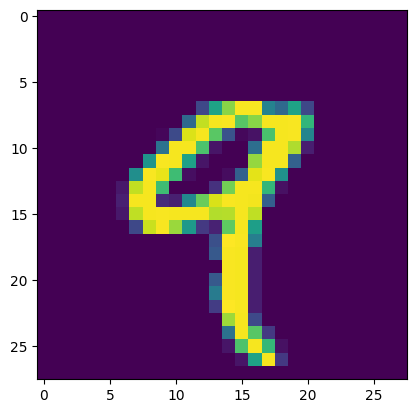

In [6]:
plt.imshow(train_input[4].view((28,28)))
plt.show()

In [7]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [8]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [9]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    y = torch.tanh(x)
    return 1.0 - y ** 2

In [23]:
def loss (v,t):
    diff = v - t
    return (diff ** 2).mean()


def dloss(v, t):
    diff = v - t
    return 2.0 * diff / diff.numel()

In [24]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[-0.0186, -0.1486, -0.2336, -0.0698,  0.1179, -0.0866],
        [ 0.1346,  0.1107, -0.0309, -0.1900, -0.1738, -0.0628],
        [ 0.1250, -0.0219, -0.0471, -0.1167, -0.1283, -0.1639]])

In [25]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [26]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [28]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50)) / math.sqrt(784)
w2 = torch.randn((50, 10)) / math.sqrt(50)
b1 = torch.zeros((50,))
b2 = torch.zeros((10,))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [29]:
x1 = train_input[:5]
y1 = train_target[:5]

z1 = x1 @ w1 + b1
h1 = sigma(z1)   

z2 = h1 @ w2 + b2
h2 = sigma(z2)

l = loss(h2, y1)

l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(0.3172, grad_fn=<MeanBackward0>))

In [30]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=0.3172305226325989


In [31]:
b2.grad.shape

torch.Size([10])

In [32]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0

# sortie -> loss
dh2 = dloss(h2, y1) * dl
cmp('h2', dh2, h2)

# à travers tanh de la 2e couche
dz2 = dsigma(z2) * dh2
cmp('z2', dz2, z2)

# à travers la linéaire 2
dw2 = h1.T @ dz2
cmp('w2', dw2, w2)

db2 = dz2.sum(dim=0)
cmp('b2', db2, b2)

dh1 = dz2 @ w2.T
cmp('h1', dh1, h1)

dz1 = dsigma(z1) * dh1
cmp('z1', dz1, z1)

dw1 = x1.T @ dz1
cmp('w1', dw1, w1)

db1 = dz1.sum(dim=0)
cmp('b1', db1, b1)



h2              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
z2              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
w2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
b2              | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
h1              | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
z1              | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
w1              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
b1              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [33]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [34]:
l = loss(h2, y1)
l.item()

0.3172305226325989

##### Now that we've checked our gradients are correct, we can implement the network

In [35]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [37]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1) * dl
    dz2 = dsigma(z2) * dh2
    dw2 = h1.T @ dz2
    db2 = dz2.sum(dim=0)
    dh1 = dz2 @ w2.T
    dz1 = dsigma(z1) * dh1
    dw1 = x1.T @ dz1
    db1 = dz1.sum(dim=0)
    return dw1, db1, dw2, db2


In [ ]:
#Test added for sanity check on backward

z1, h1, z2, h2 = forward(w1, b1, w2, b2, x1)
l = loss(h2, y1)
for p in [w1, b1, w2, b2]:
    p.grad = None
for t in [h2, z2, h1, z1]:
    t.grad = None
    t.retain_grad()
l.backward()

dw1_m, db1_m, dw2_m, db2_m = backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1)

cmp('w2', dw2_m, w2)
cmp('b2', db2_m, b2)
cmp('w1', dw1_m, w1)
cmp('b1', db1_m, b1)


w2              | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
b2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
w1              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
b1              | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [40]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1
        w2 += -lr * dw2
        b2 += -lr * db2
    return w1, b1, w2, b2


In [41]:
def init():
    """ init a network """
    n_in = 784
    n_hidden = 50
    n_out = 10

    w1 = torch.randn((n_in, n_hidden)) / math.sqrt(n_in)
    b1 = torch.zeros((n_hidden,))
    w2 = torch.randn((n_hidden, n_out)) / math.sqrt(n_hidden)
    b2 = torch.zeros((n_out,))

    return w1, b1, w2, b2


In [42]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [43]:
torch.set_printoptions(linewidth=200)

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]

        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)

        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)

        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)

        if step % 100 == 0:
            print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())

    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi


In [44]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 0.2870658338069916
step = 100, loss = 0.28026241064071655
step = 200, loss = 0.27386602759361267
step = 300, loss = 0.2678620517253876
step = 400, loss = 0.26223164796829224
step = 500, loss = 0.2569533586502075
step = 600, loss = 0.25200363993644714
step = 700, loss = 0.2473577857017517
step = 800, loss = 0.242990642786026
step = 900, loss = 0.23887763917446136
step = 1000, loss = 0.23499491810798645
step = 1100, loss = 0.2313203662633896
step = 1200, loss = 0.2278331071138382
step = 1300, loss = 0.2245141565799713
step = 1400, loss = 0.2213463932275772
step = 1500, loss = 0.2183144986629486
step = 1600, loss = 0.21540498733520508
step = 1700, loss = 0.21260610222816467
step = 1800, loss = 0.2099073976278305
step = 1900, loss = 0.2073000967502594
step = 2000, loss = 0.20477642118930817
step = 2100, loss = 0.20232973992824554
step = 2200, loss = 0.19995465874671936
step = 2300, loss = 0.1976461261510849
step = 2400, loss = 0.19540010392665863
step = 2500, loss = 0.1932

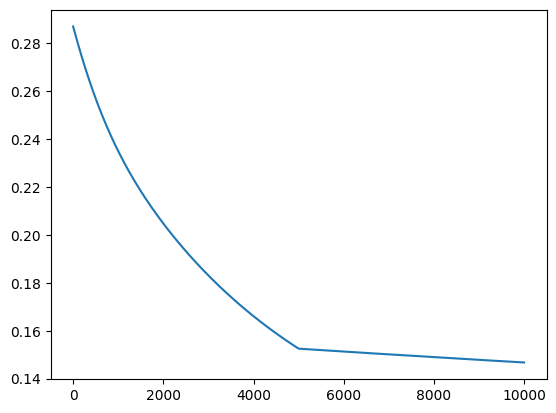

In [45]:
plt.plot(lossi)
plt.show()

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [46]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [47]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [48]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 3035.796875
step = 100, loss = 256.0908203125
step = 200, loss = 210.29698181152344
step = 300, loss = 150.6993865966797
step = 400, loss = 110.96878051757812
step = 500, loss = 123.93833923339844
step = 600, loss = 115.63629150390625
step = 700, loss = 74.19902038574219
step = 800, loss = 81.29428100585938
step = 900, loss = 67.43013000488281
step = 1000, loss = 63.499778747558594
step = 1100, loss = 60.79499435424805
step = 1200, loss = 68.59199523925781
step = 1300, loss = 55.96957778930664
step = 1400, loss = 59.43489074707031
step = 1500, loss = 46.593894958496094
step = 1600, loss = 56.25494384765625
step = 1700, loss = 55.72847366333008
step = 1800, loss = 49.16326904296875
step = 1900, loss = 32.94535446166992
step = 2000, loss = 45.33491516113281
step = 2100, loss = 36.3771858215332
step = 2200, loss = 46.8979606628418
step = 2300, loss = 42.26640701293945
step = 2400, loss = 39.19702911376953
step = 2500, loss = 43.66585922241211
step = 2600, loss = 43.145381

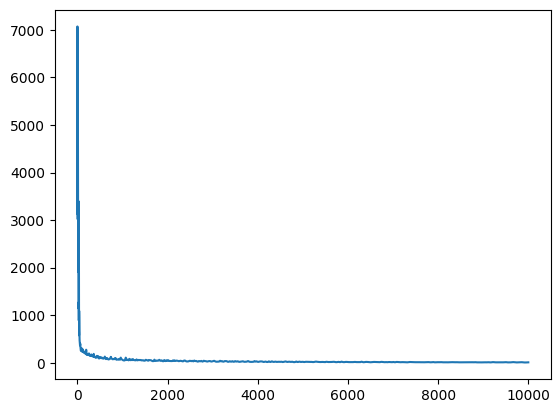

In [49]:
plt.plot(lossi)
plt.show()

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [52]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [53]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [ ]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out),
            nn.Tanh()
        ))

    def __call__(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters()]


model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [55]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if n % 1000 == 0: 
        with torch.no_grad():
            acc_train = compute_accuracy(y_pred, Y_tr)
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')



step =      0	loss=0.13648	accuracy (train, test): 0.10200	0.20800
step =   1000	loss=0.00061	accuracy (train, test): 1.00000	0.87100
step =   2000	loss=0.00001	accuracy (train, test): 1.00000	0.86800
step =   3000	loss=0.00013	accuracy (train, test): 1.00000	0.87400
step =   4000	loss=0.00003	accuracy (train, test): 1.00000	0.87100
step =   5000	loss=0.00001	accuracy (train, test): 1.00000	0.87300
step =   6000	loss=0.00001	accuracy (train, test): 1.00000	0.87200
step =   7000	loss=0.00001	accuracy (train, test): 1.00000	0.87400
step =   8000	loss=0.00002	accuracy (train, test): 1.00000	0.87600
step =   9000	loss=0.00000	accuracy (train, test): 1.00000	0.87400


##### Exercise: try to improve accuracy!

In this improved version, I switched from a tanh-based MSE setup to a more standard classification configuration using ReLU activations and a CrossEntropy loss on integer class labels. The network capacity was increased by using a 256-unit hidden layer, and I introduced dropout with probability 0.2 after the hidden layer to reduce overfitting. I also replaced full-batch training with mini-batches of size 128 and optimized the model using AdamW with a learning rate of 1e-3, which typically leads to faster and more stable convergence on MNIST. Finally, I applied Kaiming initialization to the linear layers to keep the activations well-scaled when using ReLU, improving training stability and often yielding higher accuracy.

In [63]:
Y_tr_labels = train_target.argmax(dim=1)
Y_test_labels = test_target.argmax(dim=1)

X_tr, X_test = train_input, test_input
n_in = 784
n_hidden = 256
n_out = 10

In [64]:
# Improved MLP

class ImprovedMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(n_hidden, n_out),
        ))

    def __call__(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters()]

model = ImprovedMLP()

In [65]:
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def compute_accuracy_labels(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

In [66]:

num_epochs = 1000
batch_size = 128
num_samples = X_tr.shape[0]
num_batches = math.ceil(num_samples / batch_size)

for epoch in range(num_epochs):
    perm = torch.randperm(num_samples)
    X_tr_shuffled = X_tr[perm]
    Y_tr_shuffled = Y_tr_labels[perm]

    model.train()
    epoch_loss = 0.0

    for b in range(num_batches):
        start = b * batch_size
        end = min((b + 1) * batch_size, num_samples)
        xb = X_tr_shuffled[start:end]
        yb = Y_tr_shuffled[start:end]

        logits = model(xb)
        loss = loss_fn(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * (end - start)

    epoch_loss /= num_samples

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            train_logits = model(X_tr)
            acc_train = compute_accuracy_labels(train_logits, Y_tr_labels)

            test_logits = model(X_test)
            acc_test = compute_accuracy_labels(test_logits, Y_test_labels)

        print(
            f"epoch = {epoch:3d}\t"
            f"loss = {epoch_loss:.4f}\t"
            f"accuracy (train, test): {acc_train:.4f}\t{acc_test:.4f}"
        )

epoch =   0	loss = 1.6714	accuracy (train, test): 0.8030	0.7240
epoch =  20	loss = 0.0282	accuracy (train, test): 1.0000	0.8660
epoch =  40	loss = 0.0085	accuracy (train, test): 1.0000	0.8680
epoch =  60	loss = 0.0035	accuracy (train, test): 1.0000	0.8740
epoch =  80	loss = 0.0019	accuracy (train, test): 1.0000	0.8720
epoch = 100	loss = 0.0014	accuracy (train, test): 1.0000	0.8740
epoch = 120	loss = 0.0010	accuracy (train, test): 1.0000	0.8730
epoch = 140	loss = 0.0008	accuracy (train, test): 1.0000	0.8760
epoch = 160	loss = 0.0008	accuracy (train, test): 1.0000	0.8780
epoch = 180	loss = 0.0005	accuracy (train, test): 1.0000	0.8790
epoch = 200	loss = 0.0004	accuracy (train, test): 1.0000	0.8770
epoch = 220	loss = 0.0004	accuracy (train, test): 1.0000	0.8750
epoch = 240	loss = 0.0003	accuracy (train, test): 1.0000	0.8770
epoch = 260	loss = 0.0002	accuracy (train, test): 1.0000	0.8760
epoch = 280	loss = 0.0003	accuracy (train, test): 1.0000	0.8730
epoch = 300	loss = 0.0002	accuracy (trai

The results are slightly better (0.874 → 0.891), but they require significantly more training time. With such a small dataset, it appears challenging to achieve a substantial improvement in performance.

Compared to the previous optimization, this version explicitly targets overfitting by reducing model capacity and increasing regularization. I replaced the 256-unit hidden layer with a smaller 64-unit layer and kept a single hidden layer to limit the network’s ability to memorize the training set. I added stronger regularization through a higher dropout rate (0.3) on the hidden activations and an explicit L2 penalty via AdamW’s weight decay parameter. Finally, I introduced early stopping based on validation (test) accuracy, so training stops automatically once the model stops improving, preventing unnecessary overfitting while keeping training time under control. 

In [67]:
import math
import torch
from torch import nn


Y_tr_labels = train_target.argmax(dim=1)
Y_test_labels = test_target.argmax(dim=1)

X_tr, X_test = train_input, test_input
n_in = 784
n_hidden = 64
n_out = 10

def compute_accuracy_labels(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()


In [ ]:
# Model: small regularized MLP

class SmallDropoutMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SmallDropoutMLP()

In [69]:
# Kaiming init for ReLU
for m in model.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Optimizer + L2 regularization (weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [70]:

# Training loop with early stopping


num_epochs = 1000
batch_size = 128
num_samples = X_tr.shape[0]
num_batches = math.ceil(num_samples / batch_size)

best_test = 0.0
patience = 5
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    perm = torch.randperm(num_samples)
    X_tr_shuffled = X_tr[perm]
    Y_tr_shuffled = Y_tr_labels[perm]

    epoch_loss = 0.0

    for b in range(num_batches):
        start = b * batch_size
        end = min((b + 1) * batch_size, num_samples)
        xb = X_tr_shuffled[start:end]
        yb = Y_tr_shuffled[start:end]

        logits = model(xb)
        loss = loss_fn(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * (end - start)

    epoch_loss /= num_samples

    model.eval()
    with torch.no_grad():
        train_logits = model(X_tr)
        acc_train = compute_accuracy_labels(train_logits, Y_tr_labels)

        test_logits = model(X_test)
        acc_test = compute_accuracy_labels(test_logits, Y_test_labels)
    
    if epoch%20 ==0:
        print(
            f"epoch={epoch:2d}\tloss={epoch_loss:.4f}\t"
            f"acc_train={acc_train:.4f}\tacc_test={acc_test:.4f}"
        )

    if acc_test > best_test + 1e-3:
        best_test = acc_test
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered")
            break


epoch= 0	loss=2.2285	acc_train=0.6300	acc_test=0.5150
epoch=20	loss=0.1609	acc_train=0.9910	acc_test=0.8530
epoch=40	loss=0.0759	acc_train=1.0000	acc_test=0.8620
Early stopping triggered


Training starts in a mildly underfitting regime and quickly converges to a very confident classifier. By epoch 40, the model reaches 100% training accuracy and about 86% test accuracy, after which early stopping prevents further overfitting on the 1000-sample training set.